# Q6 LGD, PD, Cutoff Optimization

In [19]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pickle
import scorecardpy as sc
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
from scipy.stats import zscore
from datetime import datetime
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel


In [3]:
df = pd.read_csv('LCOrigination.csv')
clean_df = pd.read_pickle('Q1.pkl')

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_29564/4197397062.py:1: DtypeWarning: Columns (0,14,42,98,109,110,111,114,115,116,119,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LCOrigination.csv')


### Combine the clean dataset with the performance veriables.

In [4]:
drop_col_perform = [
    "collection_recovery_fee",
    "delinq_amnt",
    "issue_d",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "next_pymnt_d",
    "pymnt_plan",
    "recoveries",
    "hardship_flag",
    "hardship_type",
    "hardship_reason",
    "hardship_status",
    "deferral_term",
    "hardship_amount",
    "hardship_start_date",
    "hardship_end_date",
    "payment_plan_start_date",
    "hardship_length",
    "hardship_dpd",
    "hardship_loan_status",
    "orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount",
    "hardship_last_payment_amount",
    "settlement_status",
    "settlement_date",
    "settlement_amount",
    "settlement_percentage",
    "settlement_term",
    "int_rate",
    "total_pymnt",
    "total_rec_int",
    "total_rec_late_fee",
    "total_rec_prncp",
    "total_rev_hi_lim",
    "out_prncp",
    "out_prncp_inv",
]

crash_record_index = df[df.loan_amnt.isna()].index
crash_record = df.loc[crash_record_index, "id"]
crash_record = pd.DataFrame(data={'index':crash_record_index, 'id': crash_record})
df.drop(index=crash_record_index, inplace=True)
clean_df.loc[:,drop_col_perform] = df.loc[:, drop_col_perform]

### Locate the Default/Charge Off Loans

In [5]:
bad_index = clean_df[(clean_df.loan_status == "Default") | (clean_df.loan_status == "Charged Off")].index

# Q6 Part 1 LGD and Loan Profit

### Exposure at Deafult

In [6]:
clean_df.loc[bad_index, 'ead'] = clean_df.loc[bad_index].funded_amnt - clean_df.loc[bad_index].total_rec_prncp

### Loss Given Default & Recovery Rate

In [9]:
clean_df.loc[bad_index, "loss"] = (
    clean_df.loc[bad_index].ead -
    clean_df.loc[bad_index].recoveries + 
    clean_df.loc[bad_index].collection_recovery_fee
).apply(lambda x: x if x >= 0 else 0)

clean_df.loc[bad_index, "lgd"] = clean_df.loc[bad_index].apply(
    lambda x: 0 if x.ead == 0 else x.loss / x.ead, axis = 1
)

clean_df.loc[bad_index, "recovery_rate"] = 1 - clean_df.loc[bad_index].lgd

### Loan Profit

In [10]:
end_loan_index = clean_df[(clean_df.loan_status == "Default") | (clean_df.loan_status == "Charged Off") | (clean_df.loan_status == "Fully Paid")].index

In [358]:
clean_df.loc[end_loan_index, "loan_profit"] = (
    clean_df.loc[end_loan_index].total_rec_int + 
    clean_df.loc[end_loan_index].total_rec_late_fee
)

### Cost of Capital

In [359]:
clean_df.loc[end_loan_index, "cost_of_cap"] = 0.5 * clean_df.loc[end_loan_index].total_rec_int
clean_df.cost_of_cap.clip(lower=0, inplace=True)

### Loan P&L

In [360]:
clean_df['profit_and_loss'] = clean_df['loan_profit'] - clean_df['cost_of_cap']
clean_df.loc[bad_index, 'profit_and_loss'] = clean_df['profit_and_loss'] - clean_df['ead'] * clean_df['lgd']

# Part 2: Calculate PD using Scorecard

### Run the scorecard to generate the predicted PD

In [21]:
app_scorecard = pickle.load(open('Q3_scorecard.pkl','rb'))

In [23]:
df_pd = sc.scorecard_ply(
    clean_df,
    app_scorecard, 
    print_step=0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scorecardpy/scorecard.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


### Split the test set wit hthe same seed used in Q2.

In [489]:
clean_df['score'] = df_pd
_, test_df = sc.split_df(clean_df,y = 'loan_status', ratio = 0.8, seed=251316935).values()

# Part 3: Cut-off Simulation

In [490]:
def portfolio_pnl (data, cut_off):
    # data subset of approved under cut off
    approved_paid_loan = data[(data.loan_status == "Fully Paid") & (data.score >= cut_off)]
    approved_bad_loan = data[
        ((data.loan_status == "Charged Off") | (data.loan_status == "Default")) & (data.score >= cut_off)]
    # calculate the sub-totals
    N = sum((data.loan_status == "Fully Paid") | (data.loan_status == "Default") | (data.loan_status == "Charged Off"))
    N_bad = sum((data.loan_status == "Default") | (data.loan_status == "Charged Off"))
    N_good = sum(data.loan_status == "Fully Paid")
    n = (len(approved_paid_loan) + len(approved_bad_loan))
    n_good = len(approved_paid_loan)
    n_bad = len(approved_bad_loan)
    total_loan = sum(approved_paid_loan.funded_amnt) + sum(approved_paid_loan.funded_amnt)
    # calcualte the acceptance rate
    accepted_good = n_good / n
    accepted_bad = n_bad / n
    accepted = (n_good + n_bad) / N
    # calcualte the accuracies
    accuracy_good = n_good / N_good
    accuracy_bad = 1 - n_bad / N_bad
    accuracy_total = (n_good + (N_bad - n_bad)) / N
    # calculate the average profit and loss in portfolio level
    avg_pnl_good = np.mean(approved_paid_loan.profit_and_loss)
    avg_pnl_bad = np.mean(approved_bad_loan.profit_and_loss)
    avg_pnl = None if n == 0 else (sum(approved_paid_loan.profit_and_loss) + sum(approved_bad_loan.profit_and_loss)) / n
    # calculate the total profit and loss in portfolio level
    tot_pnl_good = sum(approved_paid_loan.profit_and_loss)
    tot_pnl_bad = sum(approved_bad_loan.profit_and_loss)
    tot_pnl = sum(approved_paid_loan.profit_and_loss) + sum(approved_bad_loan.profit_and_loss)
    # calculate the ROI in portfolio level
    roi_good = None if n_good == 0 else tot_pnl_good / sum(approved_paid_loan.funded_amnt)
    roi_bad = None if n_bad == 0 else tot_pnl_bad / sum(approved_bad_loan.funded_amnt)
    roi = None if n == 0 else tot_pnl / total_loan
    
    return [cut_off, accepted_good, accepted_bad, accepted, 
            accuracy_good, accuracy_bad, accuracy_total, 
            avg_pnl_good, avg_pnl_bad, avg_pnl,
            tot_pnl_good, tot_pnl_bad, tot_pnl,
            roi_good, roi_bad, roi
            ]
    

In [500]:
# simulation of profit and loss under different cut offs
cut_offs = np.arange(260, 651, 5)
pnl_simulation = []
for cut_off in cut_offs:
    pnl_simulation.append(portfolio_pnl(test_df, cut_off))
simulation = np.array(pnl_simulation)
simulation_table = pd.DataFrame(
    data = simulation,
    columns = ['Cut Off', 
               'Accept Rate (Good)', 'Accept Rate (Bad)', 'Accept Rate', 
               'Accuracy (Good)', 'Accuracy (Bad)', 'Overall Accuracy', 
               'Avg. P&L (Good)', 'Avg. P&L (Bad)', 'Avg P&L',
               'Total P&L (Good)', 'Total P&L (Bad)', 'Total P&L',
               'ROI (Good)', 'ROI (Bad)', 'ROI'])
simulation_table.to_excel('Cutoff_Simulations.xlsx')
simulation_table

,Cut Off,Accept Rate (Good),Accept Rate (Bad),Accept Rate,Accuracy (Good),Accuracy (Bad),Overall Accuracy,Avg. P&L (Good),Avg. P&L (Bad),Avg P&L,Total P&L (Good),Total P&L (Bad),Total P&L,ROI (Good),ROI (Bad),ROI
0,260.0,0.667505,0.332495,0.999504,0.999889,0.001266,0.667596,1166.904354,-8819.325248,-2153.463457,1.256873e+08,-4.731744e+08,-3.474872e+08,0.082417,-0.566570,-0.113930
1,265.0,0.667663,0.332337,0.999102,0.999722,0.002141,0.667775,1166.554725,-8816.905870,-2151.321027,1.256286e+08,-4.726302e+08,-3.470016e+08,0.082395,-0.566559,-0.113792
2,270.0,0.667939,0.332061,0.998383,0.999415,0.003686,0.668085,1165.796273,-8813.515200,-2147.948577,1.255085e+08,-4.717170e+08,-3.462085e+08,0.082352,-0.566516,-0.113582
3,275.0,0.668319,0.331681,0.997454,0.999053,0.005752,0.668531,1165.193386,-8811.728135,-2143.966684,1.253981e+08,-4.706432e+08,-3.452451e+08,0.082321,-0.566629,-0.113323
4,280.0,0.668721,0.331279,0.996234,0.998431,0.008172,0.668921,1164.084173,-8809.389747,-2139.922840,1.252007e+08,-4.693731e+08,-3.441724e+08,0.082260,-0.566682,-0.113065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,630.0,0.815789,0.184211,0.000235,0.000288,0.999870,0.332900,231.546452,-9981.334657,-1649.773753,7.177940e+03,-6.986934e+04,-6.269140e+04,0.022354,-0.888923,-0.097620
75,635.0,0.846154,0.153846,0.000161,0.000204,0.999926,0.332863,223.153409,-14350.002500,-2018.870577,4.909375e+03,-5.740001e+04,-5.249063e+04,0.021466,-0.889923,-0.114759
76,640.0,0.812500,0.187500,0.000099,0.000121,0.999944,0.332813,192.166154,-14300.003333,-2525.115625,2.498160e+03,-4.290001e+04,-4.040185e+04,0.018997,-0.858000,-0.153619
77,645.0,0.777778,0.222222,0.000056,0.000065,0.999963,0.332782,237.660000,-17150.657500,-3626.410556,1.663620e+03,-3.430131e+04,-3.263769e+04,0.027498,-0.857533,-0.269733


# Par 4: Optimization - Strategy Curve

### Acceptance dilemma

Lower the acceptance of bad loan would reduce the overall acceptance rate drastically.

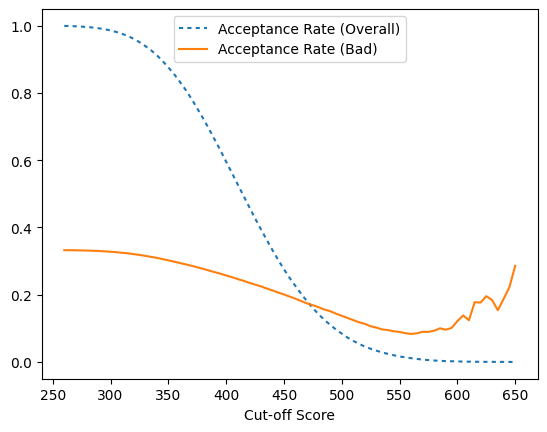

In [497]:
sns.lineplot(x=simulation[:,0], y=simulation[:,3], label = 'Acceptance Rate (Overall)', dashes=(2,2))
sns.lineplot(x=simulation[:,0], y=simulation[:,2], label = 'Acceptance Rate (Bad)')
plt.xlabel("Cut-off Score")
plt.legend(loc="upper center")
plt.show()

### Balancing Accuracy, Average P&L and Acceptance Rate

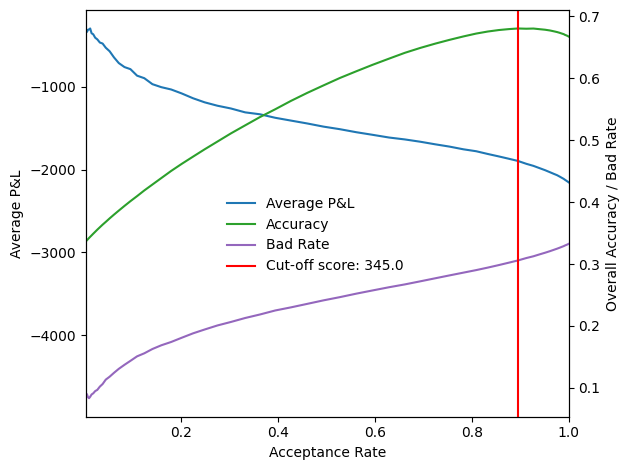

In [498]:
optimize_index = np.argmax(simulation[:,6])
fig, ax1 = plt.subplots()

ax1.set_xlabel('Acceptance Rate')
ax1.set_ylabel('Average P&L')
ax1.plot(simulation[:,3], simulation[:,9], color='tab:blue', label='Average P&L')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Overall Accuracy / Bad Rate')
ax2.plot(simulation[:,3], simulation[:,6], color='tab:green', label='Accuracy')
ax2.plot(simulation[:,3], simulation[:,2], color='tab:purple', label='Bad Rate')
ax2.tick_params(axis='y')

fig.tight_layout()

plt.axvline(x=simulation[optimize_index,3], label='Cut-off score: ' + 
    str(simulation[optimize_index,0]), color='r')
plt.xlim(0.005, 1)
fig.legend(loc='center', frameon=False)
plt.show()

In [513]:
improvements = np.array(portfolio_pnl(test_df, 345)) - np.array(portfolio_pnl(test_df, 1))
print ("Acurracy Improvement: ", improvements[6])
print ("Bad Rate Reduction: ", improvements[2])
print ("Average P&L Improvement: ", improvements[9])
print ("Total P&L Improvement: ", improvements[12])
print ("ROI Improvement: ", improvements[15])

Acurracy Improvement:  0.013236951970367006
Bad Rate Reduction:  -0.02697007413729946
Average P&L Improvement:  259.9052354877756
Total P&L Improvement:  74044720.42268658
ROI Improvement:  0.016615292470716497


The way of miximize P&L is to set a scorecard cutoff that has 0 acceptance, which is not possible. To maintain a balance between accuracy, accentance rate reduction, and average P&L, a cut-off of 345 should optimize the current origination strategy without dropping too many customers.

### Conclusion:

To optimize the accuracy of origination approval, the optimal cut off is around 340. it will reduce the bad loan rate with the consequence of rejecting 8.73% of the customers that should be approved by current mechanism.


# Q6 Complete

In [514]:
pickle.dump(clean_df, open('Q6_merged_df.pkl','wb'))
pickle.dump(simulation_table, open('Q6_scorecard_simulation.pkl','wb'))